# MCMC Sampling with Emcee Package #

This notebook contains code for determining the shape of an occulter based on the light curve using mcmc sampling. The emcee packgage https://emcee.readthedocs.io/en/stable/ is used to facilitate the sampling.

In [19]:
##Preable
from __future__ import division
import numpy as np
import pandas as pd
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import copy
import pickle
import emcee
import corner
import wandb
import warnings

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

wandb.login()
print(cpu_count())
warnings.filterwarnings("ignore", category=DeprecationWarning) 

4


## Necesary Functions ##
The following are functions for the model as well as the log probabilties that are required for sampling

In [2]:
def fillShape(grid, shapes):
    """Creates a grid with the shape bound by given points filled in.
    Points in the sublists are connected in the order they are given
    Sublists are not connected to each other

    Args:
        grid (list) - list of grid coordinates as tuples
        shapes (list) - list of shapes, each entry is a collection of points
            defining the vertices of a polygon

    Returns:
        Outline (list) - 2d array containing 0 on blank points and 1 on filled in points
    """
    # Create a grid to plot the outline on
    # need a binary image to simulate transits
    grid_df = pd.DataFrame(data=grid, columns=['x', 'y'])  # df is easier to work with
    grid_shape = [grid_df.x.max(), grid_df.y.max()]
    outline = np.zeros(grid_shape) 

    for shape in shapes:
        points_df = pd.DataFrame(data=shape, columns=['x', 'y'])
        polygon = Polygon(points_df)
        test_inside_mask = polygon.contains_points(grid)
        outline[grid_df[test_inside_mask].x, grid_df[test_inside_mask].y] = 1

    return outline

In [3]:
def generatePoints(n, xdim, ydim,xoffset = 0,yoffset = 0,rotation = 0): 
    """
    Generates the points of an n sided regular polygon inscribed in an ellipse
    
    Args: 
        n (int) - number of sides/points
        xdim (float) - half the lenght of the axis of the ellipse in the x direction
        ydim (float) - half the length of the axis of the ellipse in the y direction
        xoffset (float) - x coordinate of the center of the shape
        yoffset (float) - y coordinate of the center of the shape
        rotation (float) - rotation of the shape
    Returns:
        points (list) - list of integer tuples containing each of the points
        
    
    """
    points = []
    for i in range(n):
        y = int(ydim*np.cos(i*2*np.pi/n + np.pi/n))
        x = int(xdim*np.sin(i*2*np.pi/n + np.pi/n))
        nuy = int(x*np.sin(rotation)+y*np.cos(rotation) + yoffset)
        nux = int(x*np.cos(rotation)-y*np.sin(rotation) + xoffset)
        points.append([nuy,nux])
    return points

In [4]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

In [1]:
def extendLC(LC, overlapTimes, times):
    """
    Extends a light curve over the times in overlapTimes to the length of times will full flux value in the extension
    The overlapTimes array must be a subset of the times array
    
    Args:
        LC (list) - list of the flux values
        overlapTimes (list) - list of times value for the values in LC
        times (list) - list of times of the derisred length light curve
    
    Returns:
        extendtedLC (list) - the extended light curve
        times (list) - the same tiems array as the input
    
    
    """
    extendedLC = np.ones(len(times))##Start with full flux curve
    overlapIndex = 0
    if len(overlapTimes) > 0:
        for i in range(len(times)):##Iterate over the desired time array
            if times[i] == overlapTimes[overlapIndex]: ##When the desired time has caught up to the light curve from ebt, use the ebt values
                if overlapIndex < len(overlapTimes) - 2:##Only do this to the end of the ebt light curve
                    overlapIndex += 1
                    extendedLC[i]  = LC[overlapIndex]
        
    return extendedLC, times

In [2]:
def model(n, xdim,ydim,velocity, tRef, times):
    """
    Creates a light curve from the imput parameters, serves as the model for the mcmc sampling
    
    Args:
        n (int) - number of sides
        xdim (float) - x dimension of the shape
        ydim (float) - y dimension of the shape
        velocity (float) - pixel speed of the transiting object
        tRef (float) - time of the center of the transit
        times (list) - array of times
        
    Returns:
        planetLC (list) - array of the predicted flux from the model
    """
    points = generatePoints(n,xdim,ydim,xdim + 2,50,0)
    pointsList = [points]
    grid = []
    for i in range(100):
        for j in range(int(2*np.max((xdim,ydim))+4)):
            grid.append((i,j))
    planetGrid = fillShape(grid,pointsList)
    planet = TransitingImage(opacitymat = planetGrid, v = velocity, t_ref = tRef, t_arr = times)
    planetLC, overlapTimes = planet.gen_LC(t_arr = times)
    planetLC, times = extendLC(planetLC, overlapTimes, times)
    return planetLC

In [22]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef = theta
    fluxPredicted = model(12, xdim, ydim,velocity,tRef,times)
    lnl = -np.sum(((flux - fluxPredicted)**2) /(2*fluxErr**2))
    return lnl

In [1]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 100 and 0 < ydim < 100 and 0 < velocity < 50: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50)
    else:
        return -np.inf
    return lnPrior

In [9]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    return (lp + ll)

## Running the Simulation ##

In [10]:
times, flux, fluxErr = getData("tesslc_1421803244000000")
tRef = times[np.where(flux == np.min(flux))]
pos = [7,7,2,tRef[0]] * np.ones([16,4]) + np.random.random([16,4]) - 0.5
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr))
    sampler.run_mcmc(pos,4000, progress = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 4000/4000 [4:04:43<00:00,  3.67s/it]  


## Plotting the Results ##

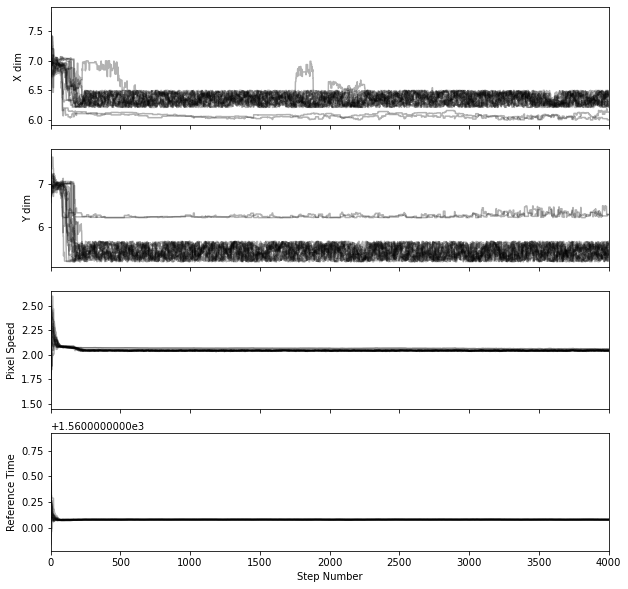

In [11]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(4,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[-1].set_xlabel("Step Number")
plt.show()

In [12]:
## Print the autocorrelation time to see if the simulation has been run for long enough
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [132.60967125 119.33332244  80.77038089  31.70080426]

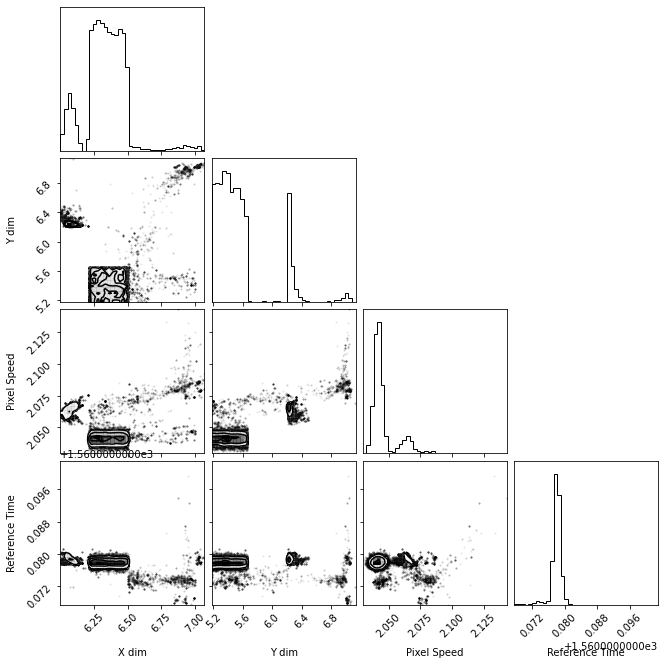

In [18]:
##Make corner plots of the four parameters
flatSamples = sampler.get_chain(discard = 50, flat = True)
fig = corner.corner(flatSamples, bins = 40, labels = labels)

In [25]:
def cutLightCurve(times, lc, t0, t1): 
    """
    Returns a subset of the inputted light curve
    
    Args: 
        times (list) - time array for the light curve
        lc (list) - flux array for the light curve
        t0 (float) - lower time bound for the portion of the light curve returned
        t1 (float) - upper time bound for the portion of the light curve returned
        
    Returns:
        newTimes (list) - time array bounded between t0 and t1
        newLc (list) - corresponding flux array for the values in newTimes
    """
    newTimes = []
    newLc = []
    i = 0
    while i < len(times):
        if times[i] > t0 and times[i] < t1:
            newTimes.append(times[i])    
            newLc.append(lc[i])
        i += 1
                
    return newTimes,newLc

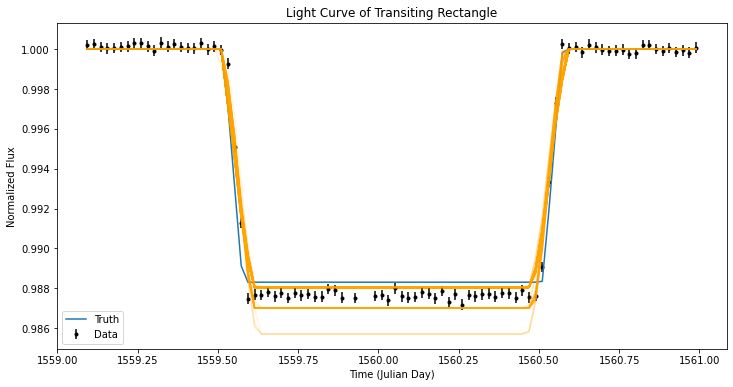

In [51]:
truthLC = model(4,4.5,11,2,1560.01,times)
newTimes, truthLC = cutLightCurve(times, truthLC, 1559,1561)##Get truth values
fig,ax = plt.subplots(figsize = (12,6))
ax.plot(newTimes,truthLC, label = "Truth")##Plot the truth values


ints = np.random.randint(len(flatSamples), size =400)##Randomly choose 400 out ouf all of the samples taken


for num in ints:
    sample = flatSamples[num]
    modelLC = model(12,sample[0],sample[1],sample[2],sample[3],times)
    newTimes,modelLC = cutLightCurve(times, modelLC, 1559, 1561) 
    ax.plot(newTimes, modelLC, color = "orange", alpha = 0.1)##For each of the chosen samples, plot in light orange

newTimes, newFlux = cutLightCurve(times, flux, 1559, 1561)
newTimes, newFluxErr = cutLightCurve(times, fluxErr, 1559, 1561)
ax.errorbar(newTimes,newFlux,yerr = newFluxErr, fmt = ".k", zorder = -1, label = "Data")##Plot the data
ax.set_title("Light Curve of Transiting Rectangle")
ax.set_ylabel("Normalized Flux")
ax.set_xlabel("Time (Julian Day)")
ax.legend()
fig.savefig("Output/1421803244lc.png")
plt.show()

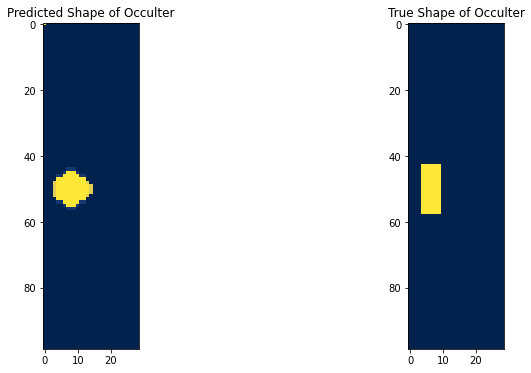

In [52]:
fig, ax = plt.subplots(1,2,figsize = (12,6))

##Initialize the predicted shape with the last simulation
xdim, ydim, velocity, tRef = flatSamples[-1]
points = generatePoints(12,xdim, ydim,xdim + 2,50)
pointsList = [points]
grid = []
for i in range(100):
    for j in range(30):
        grid.append((i,j))
planetGrid = fillShape(grid,pointsList)

##Add all of the selected simulations from the last graph
for num in ints:
    xdim, ydim, velocity, tRef = flatSamples[num]
    points = generatePoints(12,xdim, ydim,xdim + 2,50)
    pointsList = [points]
    grid = []
    for i in range(100):
        for j in range(30):
            grid.append((i,j))
    planetGrid += fillShape(grid,pointsList)

planetGrid[0][0] = len(ints)##Set the top left pixel to the number of selected simulations so that the colormap will normalize properly
ax[0].imshow(planetGrid, cmap = 'cividis')
ax[0].set_title("Predicted Shape of Occulter")

points = generatePoints(4,4.5,11,6.5,50)
pointsList = [points]
grid = []
for i in range(100):
    for j in range(30):
        grid.append((i,j))
planetGrid = fillShape(grid,pointsList)
ax[1].imshow(planetGrid, cmap = "cividis")
ax[1].set_title("True Shape of Occulter")
fig.savefig("Output/1421803244planet.png")
plt.show()